# Learning tensors for General Relativity

In [1]:

from sympy import *
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, tensor_heads
from sympy.tensor.toperators import PartialDerivative
init_printing()
import sys
print(sys.version)

Loading modified arrayop.py
3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]


## Christoffel symbols for 2D sphere

In [2]:
theta, phi = symbols('theta phi')

### Define the metric

In [3]:
L = TensorIndexType('L', dummy_name='L', dim=2)
g = tensor_heads('g', [L, L])
m, n, t  = tensor_indices('m n t', L)
metric_array = [[1,0],[0,sin(theta)**2]]
metric_repl = {L: metric_array, g(-m,-n):metric_array}
metric = g(-m,-n).replace_with_arrays(metric_repl)
g(-m,-n), metric

⎛     ⎡1     0   ⎤⎞
⎜     ⎢          ⎥⎟
⎜g  , ⎢      2   ⎥⎟
⎝ mn  ⎣0  sin (θ)⎦⎠

### Define a tensor (not a true tensor) for the Christoffel symbols

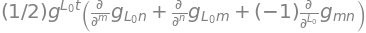

⎡                     ⎡        cos(θ)⎤⎤
⎢                     ⎢  0     ──────⎥⎥
⎢⎡0        0       ⎤  ⎢        sin(θ)⎥⎥
⎢⎢                 ⎥  ⎢              ⎥⎥
⎢⎣0  -sin(θ)⋅cos(θ)⎦  ⎢cos(θ)        ⎥⎥
⎢                     ⎢──────    0   ⎥⎥
⎣                     ⎣sin(θ)        ⎦⎦

[[[0, 0], [0, -sin(theta)*cos(theta)]], [[0, cos(theta)/sin(theta)], [cos(theta)/sin(theta), 0]]]


In [4]:
def christoffel2(metric):
    x = tensor_heads('_', [L])
    m, n, r, t, q  = tensor_indices('m n r t q', L)
    x_repl = {x(q): [theta, phi]}

    christoffel_exp = g(r,t) / 2 * (PartialDerivative(g(-r, -m), x(n)) + PartialDerivative(g(-r, -n), x(m)) - PartialDerivative(g(-m, -n), x(r)))
    gamma = tensor_heads('Gamma', [L, L, L])
    gamma_repl = {gamma(-m, -n, t):christoffel_exp.replace_with_arrays(x_repl | metric_repl)}
    gamma_result = gamma(-m, -n, t).replace_with_arrays(gamma_repl)
    return christoffel_exp, gamma, gamma_result

def test_christoffel2():
    expression, gamma, result = christoffel2(metric)
    display(expression)
    display(gamma(-m, -n, t))
    display(result)
    print(result)
test_christoffel2()
    

## Riemann Curvature Tensor $R$

In [45]:
def riemann_curvature(gamma, gamma_result):
    
    i, j, k, m, q, r  = tensor_indices('i j k m q, r', L)
    x = tensor_heads('x', [L])
    x_repl = {x(q): [theta, phi]}
    R_exp = (
        PartialDerivative(gamma(i, -j, -m), x(k)) - 
        PartialDerivative(gamma(i, -j, -k), x(m)) + 
        gamma(i, -r, -k) * gamma(r, -j, -m) - 
        gamma(i, -r, -m) * gamma(r, -j, -k))
    
    R = tensor_heads('R', [L, L, L, L])
    gamma_repl = {gamma(i, -j, -m) : gamma_result}
    R_repl = {R(i, -k, -m, -j): R_exp.replace_with_arrays(x_repl | gamma_repl)}  # swapping final two indices, seems necessary
    result = R(i, -k, -j, -m).replace_with_arrays(R_repl)

    return R_exp, R, result

def show_one(T, Ta, ixstr):
    ixs = [int(c) for c in ixstr]
    print(f'{T}[{ixstr}] = {Ta[ixs]}')
    
def test_riemann_curvature():
    gamma = tensor_heads('Gamma', [L, L, L])
    gamma_result = [[[0, 0], [0, -sin(theta)*cos(theta)]], 
                    [[0, cos(theta)/sin(theta)], [cos(theta)/sin(theta), 0]]]
    R_exp, R, R_result = riemann_curvature(gamma, gamma_result)
    i, j, k, m  = tensor_indices('i j k m', L)
    display(R_exp)
    display(R(-j, -k, -m, i))
    display(R_result)

    show_one('R', R_result, '0101')
    show_one('R', R_result, '0110')
    show_one('R', R_result, '1010')
    show_one('R', R_result, '1001')
    

test_riemann_curvature()

⎡         ⎡             2   ⎤⎤
⎢⎡0  0⎤   ⎢   0      sin (θ)⎥⎥
⎢⎢    ⎥   ⎢                 ⎥⎥
⎢⎣0  0⎦   ⎢    2            ⎥⎥
⎢         ⎣-sin (θ)     0   ⎦⎥
⎢                            ⎥
⎢⎡0  -1⎤        ⎡0  0⎤       ⎥
⎢⎢     ⎥        ⎢    ⎥       ⎥
⎣⎣1  0 ⎦        ⎣0  0⎦       ⎦

R[0101] = sin(theta)**2
R[0110] = -sin(theta)**2
R[1010] = 1
R[1001] = -1
